---
title: "Data Cleaning"
format:
    html: 
        code-fold: false
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

# Code 

Provide the source code used for this section of the project here.

If you're using a package for code organization, you can import it at this point. However, make sure that the **actual workflow steps**—including data processing, analysis, and other key tasks—are conducted and clearly demonstrated on this page. The goal is to show the technical flow of your project, highlighting how the code is executed to achieve your results.

If relevant, link to additional documentation or external references that explain any complex components. This section should give readers a clear view of how the project is implemented from a technical perspective.

Remember, this page is a technical narrative, NOT just a notebook with a collection of code cells, include in-line Prose, to describe what is going on.

In [2]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from langdetect import detect, DetectorFactory, LangDetectException

# Set a consistent seed for langdetect
DetectorFactory.seed = 0

# Download VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Read CSV file
df = pd.read_csv('../../data/raw-data/spotify_youtube.csv', encoding='iso-8859-1')

def clean_comments(comments):
    english_comments = []
    try:
        comments = eval(comments)  # Converts string representation of list to list
        for comment in comments:
            # Remove HTML tags and additional cleaning
            comment_text = re.sub(r'<[^>]+>', '', comment)
            comment_text = comment_text.replace('_', '')
            comment_text = re.sub(r"[^\w\s]", "", comment_text)  # Remove punctuation
            comment_text = re.sub(r"\d+", "", comment_text)  # Remove numbers
            comment_text = comment_text.lower().strip()
            # Detect language after cleaning
            if detect(comment_text) == 'en':
                english_comments.append(comment_text)
    except LangDetectException:
        pass  # Ignore comments where language detection fails
    except SyntaxError:
        pass  # Handle syntax error if eval fails
    return english_comments

def average_sentiment_score(comments):
    # Clean comments first
    clean_english_comments = clean_comments(comments)
    # Perform sentiment analysis on cleaned English comments
    if clean_english_comments:
        scores = [sia.polarity_scores(comment)['compound'] for comment in clean_english_comments]
        return sum(scores) / len(scores) if scores else 0
    else:
        return 0

# Apply the function to compute the mean sentiment score
df['Mean Sentiment Score'] = df['Comments'].apply(average_sentiment_score)

# Add one more col filled with processed comments
df['Processed_Comments'] = df['Comments'].apply(clean_comments)

# Transfer the duration to seconds
def duration_to_seconds(duration):
    # Regular expression to extract the time parts from the ISO 8601 format
    pattern = re.compile('PT(?:(\d+)H)?(?:(\d+)M)?(?:(\d+)S)?')
    parts = pattern.match(duration)
    
    # Extract hours, minutes, and seconds from the match object
    hours = int(parts.group(1)) if parts.group(1) else 0
    minutes = int(parts.group(2)) if parts.group(2) else 0
    seconds = int(parts.group(3)) if parts.group(3) else 0
    
    # Convert all to seconds
    total_seconds = hours * 3600 + minutes * 60 + seconds
    return total_seconds

df['Duration_seconds'] = df['Duration'].apply(duration_to_seconds)

# Replace Definition with hd=1, sd=0
def convert_definition(definition):
    if definition == 'hd':
        return 1
    elif definition == 'sd':
        return 0
    return None
df['Definition'] = df['Definition'].apply(convert_definition)

# Factorize the 'genre' column
labels, unique = pd.factorize(df['genre'])

# Add the labels as a new column in the DataFrame
df['genre_label'] = labels

# Display DataFrame head
#print(df[['Comments', 'Mean Sentiment Score']].head())

# Save the modified DataFrame to a new CSV file
df.to_csv('../../data/processed-data/Updated_Data_with_Sentiments.csv', index=False)

<>:58: SyntaxWarning: invalid escape sequence '\d'
<>:58: SyntaxWarning: invalid escape sequence '\d'
/var/folders/1f/twjj6zg12057l62kw8fwf3f40000gn/T/ipykernel_90030/3613333924.py:58: SyntaxWarning: invalid escape sequence '\d'
  pattern = re.compile('PT(?:(\d+)H)?(?:(\d+)M)?(?:(\d+)S)?')
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/CuiCuiLee/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# data standarlized
from sklearn.preprocessing import StandardScaler
columns_to_scale = [
    'Days Since Published', 'View Count', 'Like Count', 'Comment Count',
    'Subscriber Count', 'Definition', 'Mean Sentiment Score',
    'Duration_seconds', 'genre_label', 'singer_followers', 'singer_popularity', 'Duration (ms)'
]

# initialize StandardScaler
scaler = StandardScaler()

df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

print(df[columns_to_scale].head())

df.to_csv('../../data/processed-data/Normalized_Data_with_Sentiments.csv', index=False)

   Days Since Published  View Count  Like Count  Comment Count  \
0              1.168381   -0.264997   -0.403455      -0.358746   
1              1.168381   -0.065329   -0.161714      -0.250200   
2              1.168381    0.309538    0.068574      -0.030982   
3              0.902404   -0.402018   -0.461648      -0.402329   
4              1.167881   -0.148921   -0.290536      -0.352329   

   Subscriber Count  Definition  Mean Sentiment Score  Duration_seconds  \
0         -0.582925    0.418985              0.366239         -0.039614   
1         -0.582925    0.418985             -0.984291         -0.001872   
2         -0.582925    0.418985              1.334540         -0.054710   
3         -0.582925    0.418985              1.577078         -0.125161   
4         -0.582925    0.418985              0.468128         -0.092452   

   genre_label  singer_followers  singer_popularity  Duration (ms)  
0    -1.319198         -0.438837          -0.184437       0.024286  
1    -1.319198

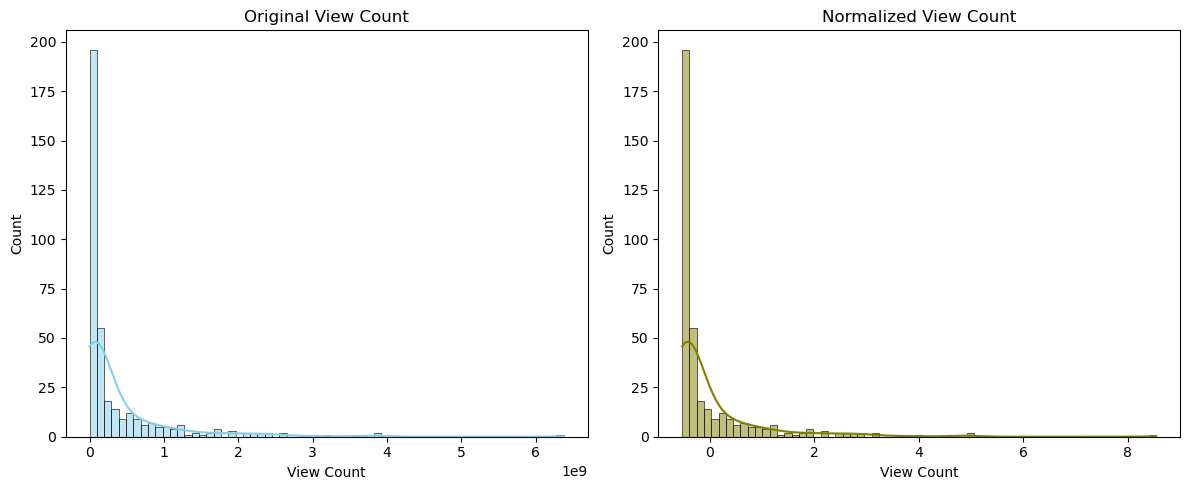

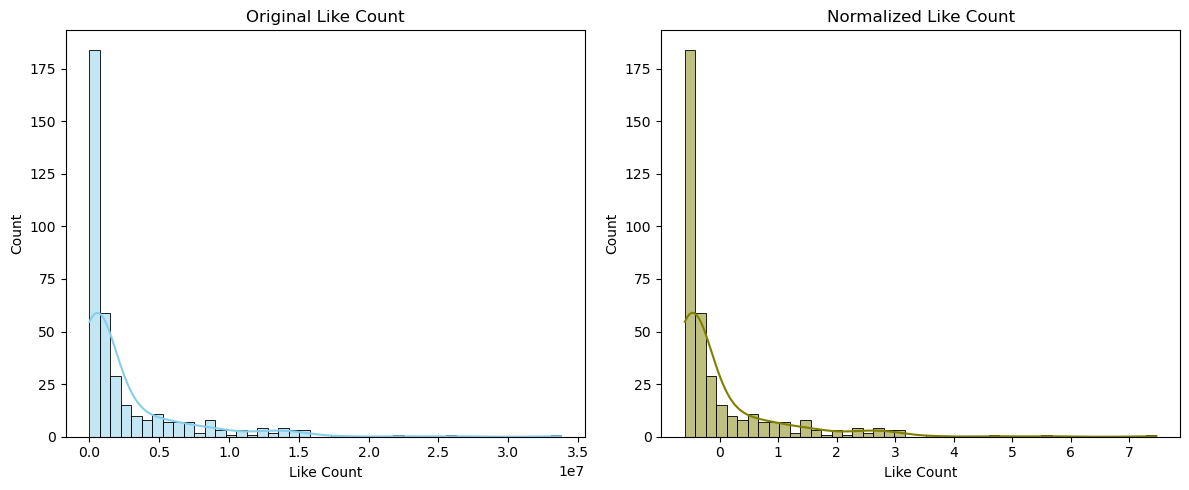

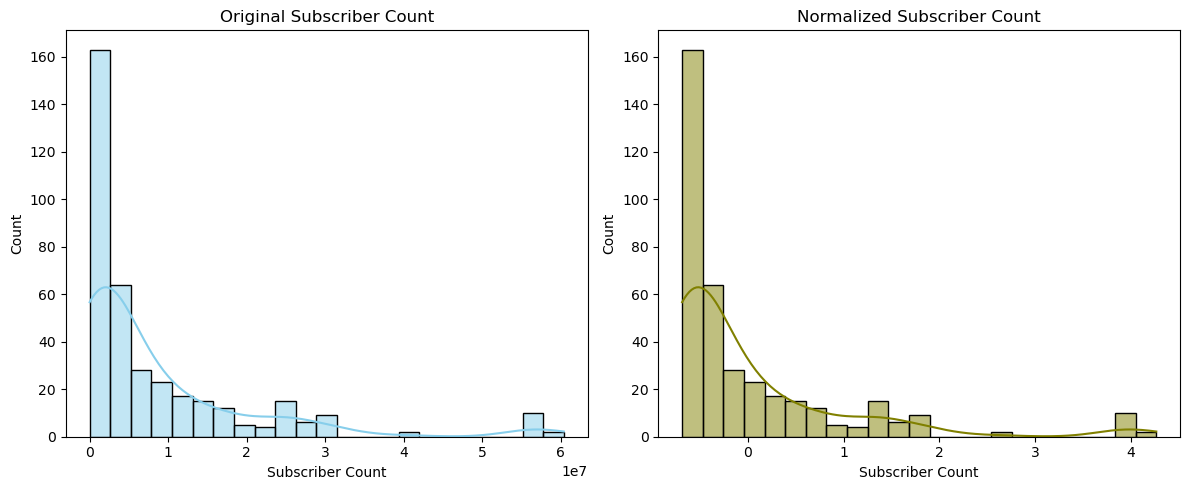

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the normalized data
df_normalized = pd.read_csv('../../data/processed-data/Normalized_Data_with_Sentiments.csv')

def plot_data_comparisons(df_original, df_normalized, column_name):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Original Data Histogram
    sns.histplot(df_original[column_name], ax=axes[0], kde=True, color='skyblue')
    axes[0].set_title(f'Original {column_name}')
    
    # Normalized Data Histogram
    sns.histplot(df_normalized[column_name], ax=axes[1], kde=True, color='olive')
    axes[1].set_title(f'Normalized {column_name}')
    
    plt.tight_layout()
    plt.show()

# Assuming the original data is still available and named df
df_original = pd.read_csv('../../data/raw-data/spotify_youtube.csv', encoding='iso-8859-1')

# Example variables to visualize
variables_to_visualize = ['View Count', 'Like Count', 'Subscriber Count']

for variable in variables_to_visualize:
    plot_data_comparisons(df_original, df_normalized, variable)
